# Milestone 1 a gratuitously complex adding machine
## Goal: Create an FFN that can add 2 integers betwen -10 and +10

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_17212\4270720995.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Generate data

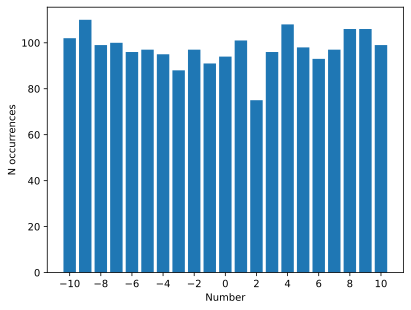

In [2]:
N = 1024

# Generate random integer pairs between [-10, +10]
data = np.random.randint(-10, 11, size=(N, 2))
labels = np.vstack(np.sum(data, axis=1))

# Show the distribution
plt.figure()
plt.bar(range(-10, 11), np.histogram(data, bins=21)[0])
plt.ylabel("N occurrences")
plt.xlabel("Number")
plt.xticks(range(-10, 11, 2))
plt.show()

In [3]:
# Step 1: convert to tensor
dataT = torch.tensor(data).float()
labelsT = torch.tensor(labels).float()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create DL model

In [4]:
# create a class for the model
def createTheADDNet():

    # model architecture
    net = nn.Sequential(
        nn.Linear(2,1)
    )

    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=.01)

    return net,lossfun,optimizer

# Create a function that trains the model

In [13]:
numepochs = 20

def function2trainTheModel():

    # create a new model
    net,lossfun,optimizer = createTheADDNet()

    # initialize losses
    losses    = torch.zeros(numepochs)
    trainAcc  = []
    testAcc   = []


    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.round(yHat).long() == torch.round(y).long()
            batchAcc.append( 100 * torch.mean(matches.float()) )
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)

        # compute accuracy
        matches = torch.round(yHat).long() == torch.round(y).long()
        testAcc.append( 100 * torch.mean(matches.float()) )

    # end epochs

    # function output
    return trainAcc,testAcc,losses,net

# Test the model with a single run

In [14]:
trainAcc,testAcc,losses,net = function2trainTheModel()

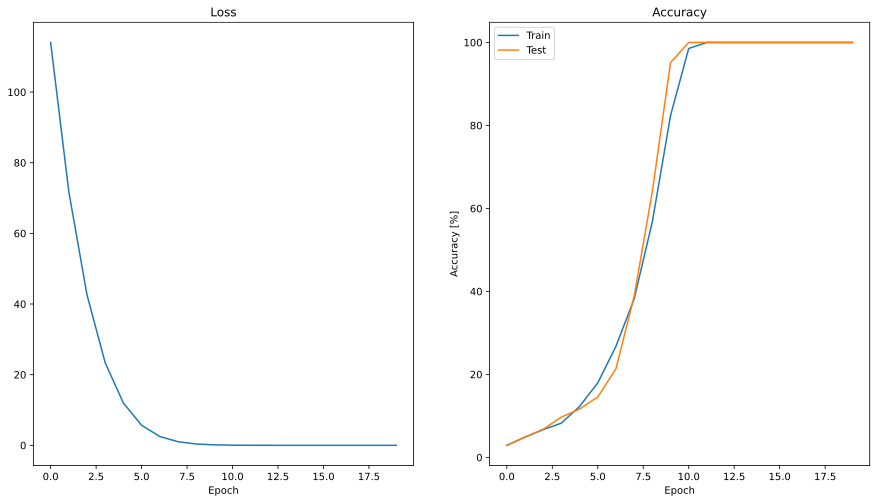

In [15]:
plt.figure(figsize=(15, 8))

plt.subplot(121)
plt.plot(losses)
plt.xlabel("Epoch")
plt.title("Loss")

plt.subplot(122)
plt.plot(trainAcc, label="Train")
plt.plot(testAcc, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.title("Accuracy")

plt.show()

# Check the results of 10 models

In [17]:
from time import perf_counter

for i in range(10):
    start = perf_counter()
    finalAcc = function2trainTheModel()[1][-1]
    end = perf_counter()
    print(f"[{end - start:.1f}s] Run {i} finished. Accuracy: {finalAcc:.2f}%")

[0.3s] Run 0 finished. Accuracy: 100.00%
[0.4s] Run 1 finished. Accuracy: 100.00%
[0.3s] Run 2 finished. Accuracy: 100.00%
[0.3s] Run 3 finished. Accuracy: 100.00%
[0.3s] Run 4 finished. Accuracy: 100.00%
[0.3s] Run 5 finished. Accuracy: 100.00%
[0.3s] Run 6 finished. Accuracy: 100.00%
[0.3s] Run 7 finished. Accuracy: 100.00%
[0.3s] Run 8 finished. Accuracy: 100.00%
[0.3s] Run 9 finished. Accuracy: 100.00%


# Visualize results

100.0


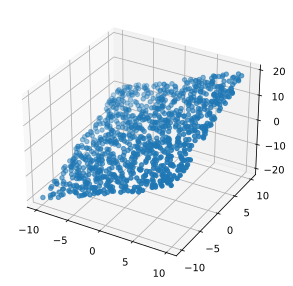

In [59]:
numbers1 = np.linspace(-10, 10, 1000)
np.random.shuffle(numbers1)
numbers2 = numbers1.copy()
np.random.shuffle(numbers2)

number_pairs = np.dstack((numbers1, numbers2))[0]
sums = np.sum(number_pairs, axis=1)

yHat = net(torch.tensor(number_pairs).float()).detach().numpy().flatten()

print(100 * np.mean(np.round(yHat).astype(int) == np.round(sums).astype(int)))

plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(numbers1, numbers2, sums)

plt.show()

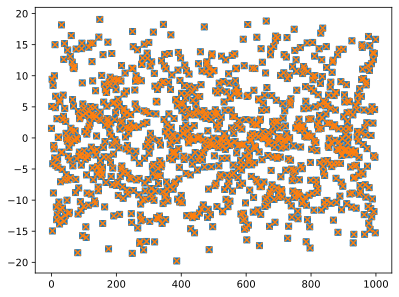

In [74]:
plt.figure()

plt.scatter(range(len(sums)), sums, marker='s')
plt.scatter(range(len(yHat)), sums, marker='x')

plt.show()

In [57]:
incorrect = number_pairs[np.round(yHat).astype(int) != np.round(sums).astype(int)]
correct = sums[np.round(yHat).astype(int) != np.round(sums).astype(int)]
predictions = yHat[np.round(yHat).astype(int) != np.round(sums).astype(int)]
print(incorrect)
print(correct)
print(predictions)

[[ 8.56458565  5.93555936]
 [ 0.63690637  9.86319863]
 [ 5.86935869 -2.36932369]
 [ 5.67095671  7.82917829]
 [ 2.97132971  4.52874529]
 [ 9.6697967   5.8303583 ]]
[14.500145 10.500105  3.500035 13.500135  7.500075 15.500155]
[14.499904  10.49989    3.499869  13.4999     7.4998817 15.499907 ]
